# Road Segment Creation Dates

Evaluating the creation dates in the roadseg table, by province.

In [1]:
%matplotlib inline
# required modules
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from reporting import *

In [2]:
# set up the arguments for the dataset
data_dir = Path('../../nrn_data')

Data all exists within a set of GeoPackage files, broken up by province. The exact path to those files is not really consistent between the provinces, so a convenience function was created to find them all and pull out the release version information.

In [3]:
roadseg = load_all_roadseg(data_dir)
roadseg['datasetnam'].value_counts()

Ontario                      656621
Québec                       440398
Alberta                      413349
Saskatchewan                 291003
British Columbia             263584
Nova Scotia                  111570
Manitoba                     110604
New Brunswick                 67930
Newfoundland and Labrador     44484
Prince Edward Island          18140
Northwest Territories          6793
Yukon Territory                6591
Nunavut                        4242
Name: datasetnam, dtype: int64

Dates in the data are inconsistently formatted. The rules for the dates allow anything from just the year, to year-month, to a full year-month-day. The data is always formatted as YYYYMMDD though, and when data is missing it is normalized to being the first month/day of whatever attribute is missing. This means checking the length of the data in the column lets us know how to fill it in to get a normalized format that can be converted to the date type.

In [5]:
# Quebec contains a single data error. It isn't clear what the proper value is, so it is shifted to December.
roadseg['credate'] = roadseg['credate'].str.replace('20141401','20141201')

# normalize the created and revised dates
roadseg['credate_norm'] = roadseg['credate'].apply(lambda v: date_normalize(v))

# convert the normalized dates to proper DateTime dtypes
roadseg['created'] = pd.to_datetime(roadseg['credate_norm'], format="%Y%m%d")

# Analysis

With all the data loaded and the date columns properly converted, start analyzing information by province.

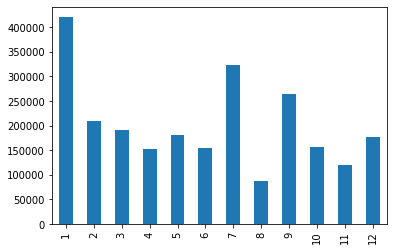

In [6]:
# look at the months in which data was created
roadseg['created'].dt.month.value_counts(sort=False).plot(kind='bar')

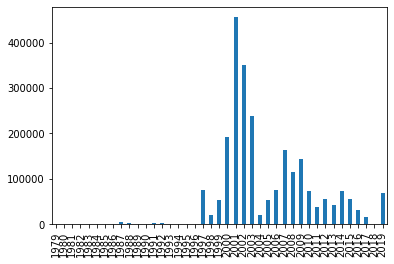

In [7]:
# look at the years in which data was created
roadseg['created'].dt.year.value_counts(sort=False).plot(kind='bar')

In [9]:
roadseg.groupby('datasetnam')['created'].agg([min, max])

,min,max
datasetnam,,
Alberta,2000-09-01,2017-02-15
British Columbia,1979-07-01,2017-03-01
Manitoba,2000-07-01,2012-10-01
New Brunswick,2019-09-26,2019-09-26
Newfoundland and Labrador,2001-03-01,2012-09-01
Northwest Territories,1999-07-01,2017-11-01
Nova Scotia,1986-01-01,2017-03-13
Nunavut,1982-01-01,2013-01-01
Ontario,1999-12-01,2016-04-19


In [10]:
roadseg['created'].dt.year.value_counts(sort=False)

1979       102
1980       107
1981       855
1982       388
1983        73
1984       252
1985       212
1986      1290
1987      5539
1988      2009
1989       609
1990        74
1991      3543
1992      2582
1993       483
1994        40
1995         1
1996      1670
1997     75745
1998     20595
1999     54436
2000    191125
2001    455813
2002    349674
2003    238333
2004     21009
2005     54193
2006     76503
2007    162590
2008    116155
2009    144526
2010     73446
2011     37550
2012     56762
2013     41651
2014     72926
2015     54955
2016     32185
2017     16925
2018       453
2019     67930
Name: created, dtype: int64

In [11]:
roadseg['created'].dt.is_month_start.value_counts()

True     1862760
False     572549
Name: created, dtype: int64